In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from influenza_USA.NC_forecasts.utils import get_NC_influenza_data, simulate_geometric_random_walk, get_historic_drift

## Visualise baseline model

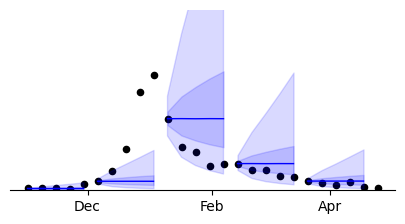

In [4]:
# settings
start_visualisation_month = 11
end_visualisation_month = 5
focal_season = '2014-2015'
seasons = ['2014-2015','2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2023-2024']
drift_horizon = 4
number_simulations = 5
sigma = 0.375

# format dates
start_visualisation = datetime(int(focal_season[0:4]), start_visualisation_month, 1)
end_visualisation = datetime(int(focal_season[0:4])+1, end_visualisation_month, 1)

# load NC data
data = 7*get_NC_influenza_data(start_visualisation, end_visualisation, focal_season)['H_inc']

# find good equi-spaced startdates for the baseline visualisation
indices = np.linspace(0, len(data.index) - 1, number_simulations+1, dtype=int)
selected_dates = data.index[indices][:-1]

# simulate baseline model on these dates
simout = []
for date in selected_dates:
    mu, _ = get_historic_drift(focal_season, seasons, date, drift_horizon) # not drift used
    simout.append(simulate_geometric_random_walk(0, sigma, date, data.loc[date], 100000, 4))

# make a figure
fig,ax=plt.subplots(figsize=(8.3/2, 11.7/5))
## data
ax.scatter(data.index, data, marker='o', s=20, color='black')
## model
for sim in simout:
    x = sim['target_end_date'].unique()
    ax.plot(x, list(sim.loc[sim['output_type_id']==0.50, 'value'].values), color='blue', linewidth=1)
    ax.fill_between(x, list(sim.loc[sim['output_type_id']==0.025, 'value'].values),
                        list(sim.loc[sim['output_type_id']==0.975, 'value'].values),
                            color='blue', alpha=0.15)
    ax.fill_between(x, list(sim.loc[sim['output_type_id']==0.25, 'value'].values),
                       list(sim.loc[sim['output_type_id']==0.75, 'value'].values),
                           color='blue', alpha=0.15)
## formatting
# no spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
# months only
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# no ticks
ax.set_yticks([])
ax.set_ylim([0,1000])
plt.tight_layout()
plt.savefig(f'baseline-model_{focal_season}.pdf')
plt.show()
plt.close()
